<a href="https://colab.research.google.com/github/dasjyotishka/Predicting-Airbnb-Prices-in-New-York-City/blob/main/Predicting_price_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing libraries

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 24.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost as xgb
import catboost as cb
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from yellowbrick.target import BalancedBinningReference
from yellowbrick.regressor import PredictionError, ResidualsPlot
import os
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#Read dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ensemble/AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#EDA and Data Visualisations

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

###Room type analysis

In [ ]:
room_type = data.groupby('room_type').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()
    
room_type

,room_type,avg_price,count
0,Entire home/apt,211.794246,25409
1,Private room,89.780973,22326
2,Shared room,70.127586,1160


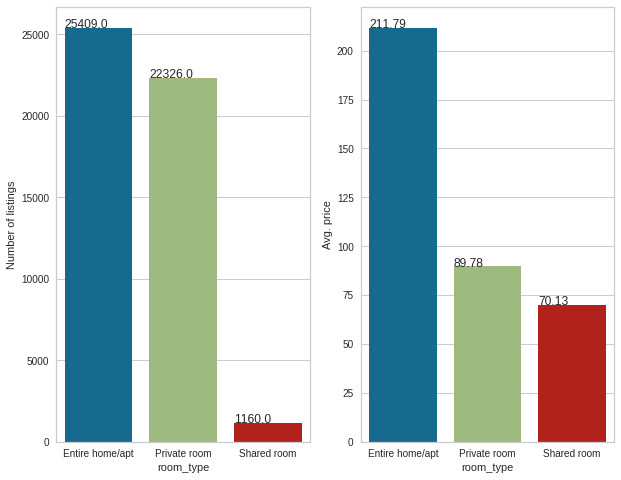

In [ ]:
fig,(chart_1,chart_2) = plt.subplots(1,2,figsize=(10,8))
ax = sns.barplot(x='room_type', y = 'avg_price', data=room_type, ax=chart_2)
for p in chart_2.patches:
    chart_2.annotate("{:.2f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_2.set_ylabel("Avg. price")

ax = sns.barplot(x='room_type', y = 'count', data=room_type, ax=chart_1)
for p in chart_1.patches:
    chart_1.annotate("{:.1f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_1.set_ylabel("Number of listings")
plt.show()

We see maximum listings are either Private room or Entire home/apt

Also, Entire home/apt are most expensive.

###Neighbourhood_group(large area) analysis


In [ ]:
#Avg. price and listings per neighbourhood_group(large area)
neighbourhood_group_df = data.groupby('neighbourhood_group').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()
    
neighbourhood_group_df

,neighbourhood_group,avg_price,count
0,Bronx,87.496792,1091
1,Brooklyn,124.383207,20104
2,Manhattan,196.875814,21661
3,Queens,99.517649,5666
4,Staten Island,114.812332,373


Text(0, 0.5, '')

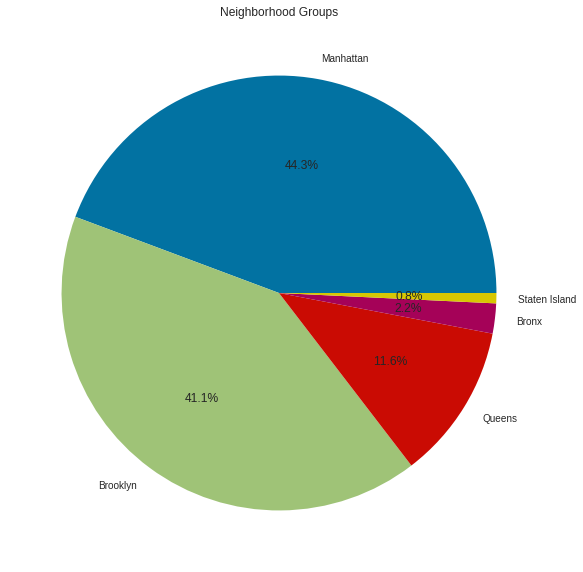

In [ ]:
#Pie chart to show listings in each neighbourhood group
ax1 = data.neighbourhood_group.value_counts().plot.pie(title='Neighborhood Groups',
                                               figsize=(15,10),
                                              autopct='%1.1f%%')
ax1.set_ylabel(None)

We see that more than 85% of listings are located in Manhattan and Brooklyn.

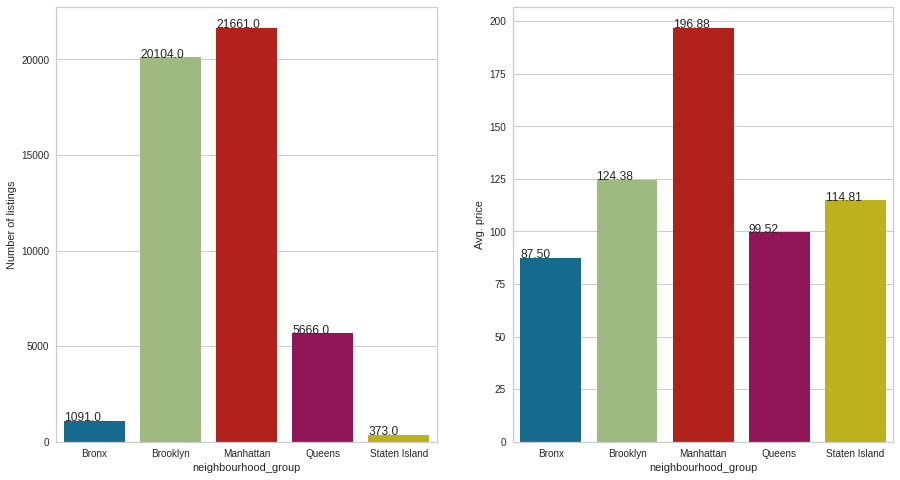

In [ ]:
fig,(chart_1,chart_2) = plt.subplots(1,2,figsize=(15,8))
ax = sns.barplot(x='neighbourhood_group', y = 'avg_price', data=neighbourhood_group_df, ax=chart_2)
for p in chart_2.patches:
    chart_2.annotate("{:.2f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_2.set_ylabel("Avg. price")

ax = sns.barplot(x='neighbourhood_group', y = 'count', data=neighbourhood_group_df, ax=chart_1)
for p in chart_1.patches:
    chart_1.annotate("{:.1f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_1.set_ylabel("Number of listings")
plt.show()

We see that highest average price is of listings are located in Manhattan

###Neighbourhood Analysis

In [ ]:
print("There are", data["neighbourhood"].nunique(), "distinct values.")

There are 221 distinct values.


Text(0.5, 1.0, 'Top 10 Neighbourhood')

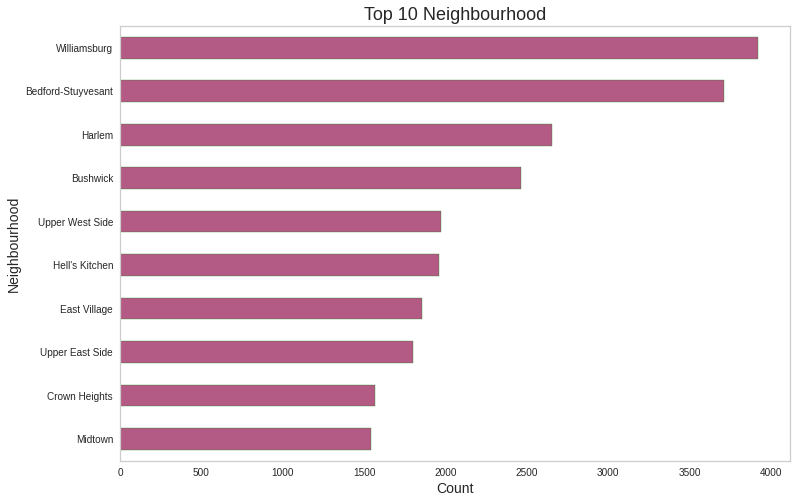

In [ ]:
plt.figure(figsize=(12,8))
data["neighbourhood"].value_counts().head(10).sort_values().plot(kind = "barh", 
                                                               color = "#b35b84",
                                                               edgecolor="green",
                                                               grid =False)
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=10)
plt.xlabel("Count", size = 14)
plt.ylabel("Neighbourhood", size = 14)
plt.title("Top 10 Neighbourhood", size = 18)

Text(0.5, 1.0, 'Top 10 Neighbourhood with Highest Avg. Prices')

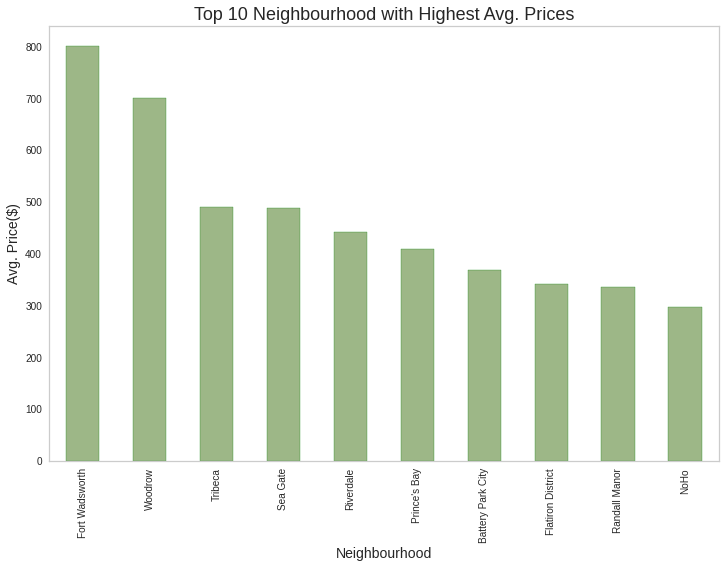

In [ ]:
plt.figure(figsize=(12,8))
top_10_n_p_mean_df = data.groupby("neighbourhood")["price"].agg("mean").sort_values(ascending=False).head(10)
top_10_n_p_mean_df.sort_values(ascending=False).plot(kind = "bar", 
                                                     color = "#9db787", 
                                                     edgecolor="green",
                                                     grid = False)
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=10)
plt.xlabel("Neighbourhood", size = 14)
plt.ylabel("Avg. Price($)", size = 14)
plt.title("Top 10 Neighbourhood with Highest Avg. Prices", size = 18)

###Longitude and latitude per neighbourhood_group and room type 

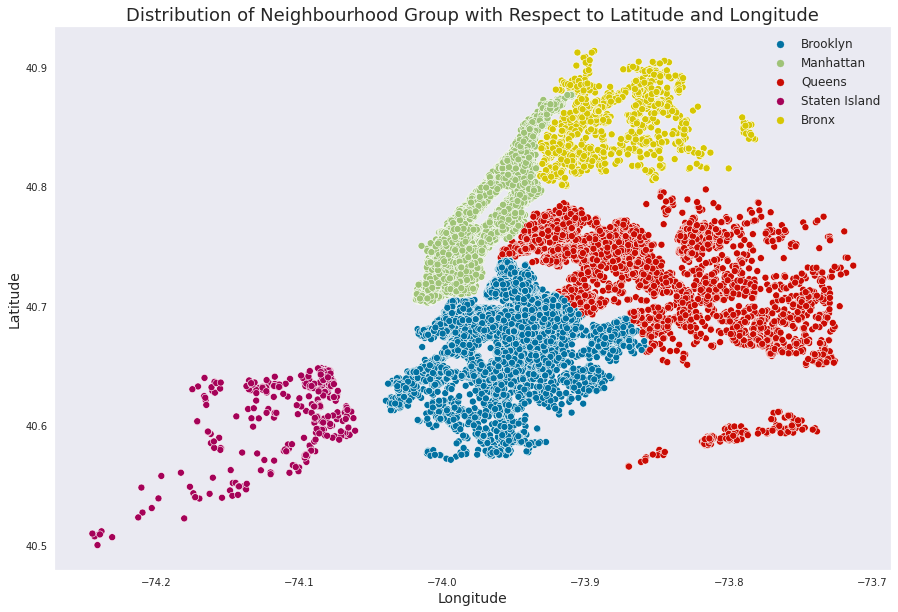

In [ ]:
plt.figure(figsize=(15,10))
sns.set_style("dark", {'axes.grid' : False})
sns.scatterplot(data=data, x="longitude", y="latitude", hue="neighbourhood_group")
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Distribution of Neighbourhood Group with Respect to Latitude and Longitude", fontsize=18)
plt.legend(prop={"size":12})

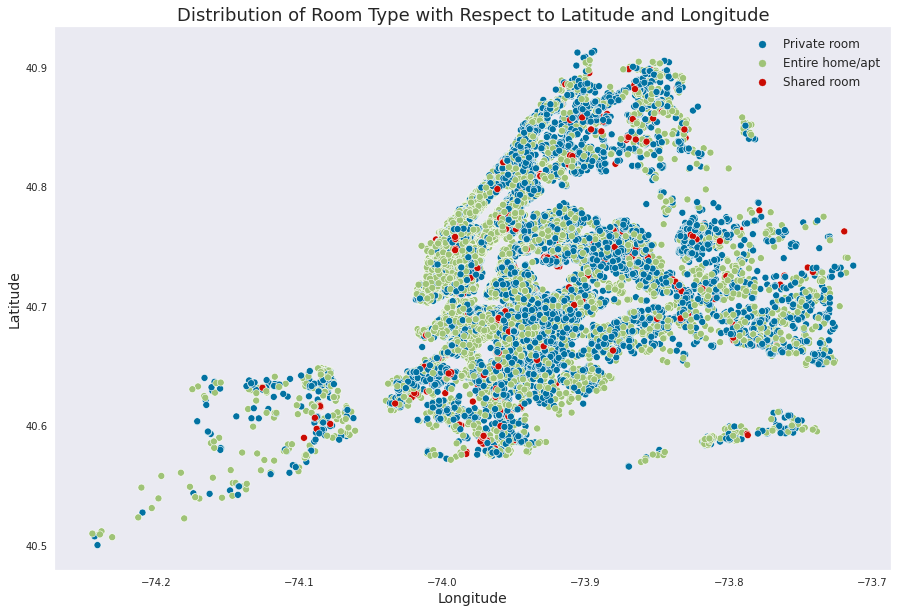

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(data = data, x="longitude", y="latitude", hue="room_type")
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("Distribution of Room Type with Respect to Latitude and Longitude", fontsize=18)
plt.legend(prop={"size":12})

###Price Distribution analysis

Text(0.5, 1.0, 'Price Distribution After Log Transformation')

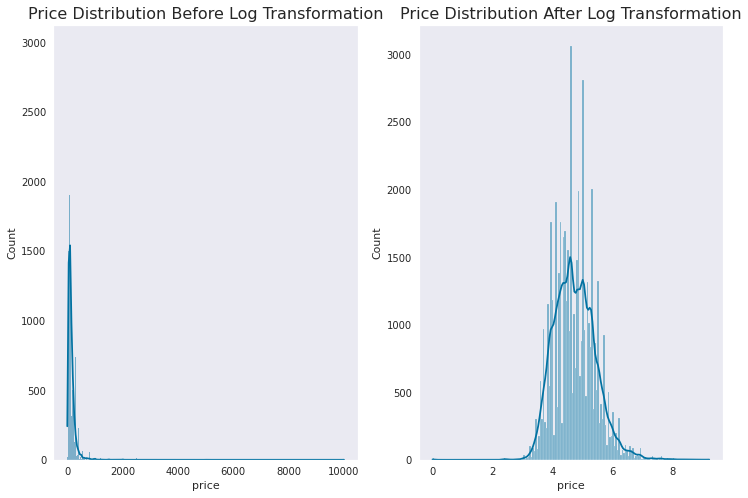

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,8))
sns.histplot(data=data, x="price", kde=True, ax=ax[0]).set_title("Price Distribution Before Log Transformation",
                                                                size = 16)
sns.histplot(np.log1p(data.price), kde=True, ax=ax[1]).set_title("Price Distribution After Log Transformation",
                                                                size = 16)

The graph on the left shows that there is a right skewed distribution. To make a better statistical analysis and to get better scores, we will be applied log transformation for the price column

#Outlier detection and Removal

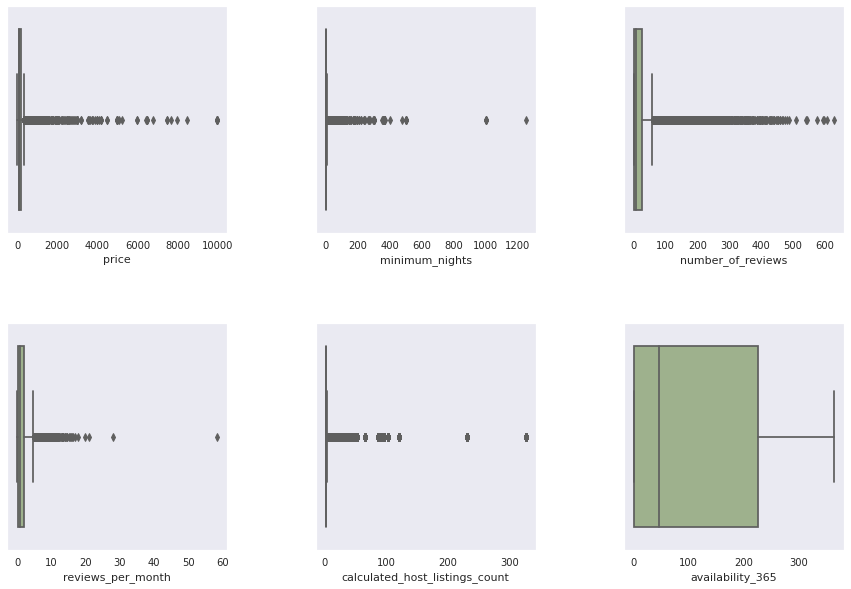

In [ ]:
columns = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count",
          "availability_365"]
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for num, column_name in enumerate(columns):
    ax = fig.add_subplot(2, 3, num +1)
    ax = sns.boxplot(x=data[column_name], color='#9db787')

In [ ]:
q1_price = data["price"].quantile(0.25)
q3_price = data["price"].quantile(0.75)
iqr_price = q3_price - q1_price
lower_limit_price = q1_price - 1.5 * iqr_price
upper_limit_price = q3_price + 1.5 * iqr_price

df_filter_price = data[(data["price"] > lower_limit_price) & (data["price"] < upper_limit_price)]

df = df_filter_price

#Correlation matrix

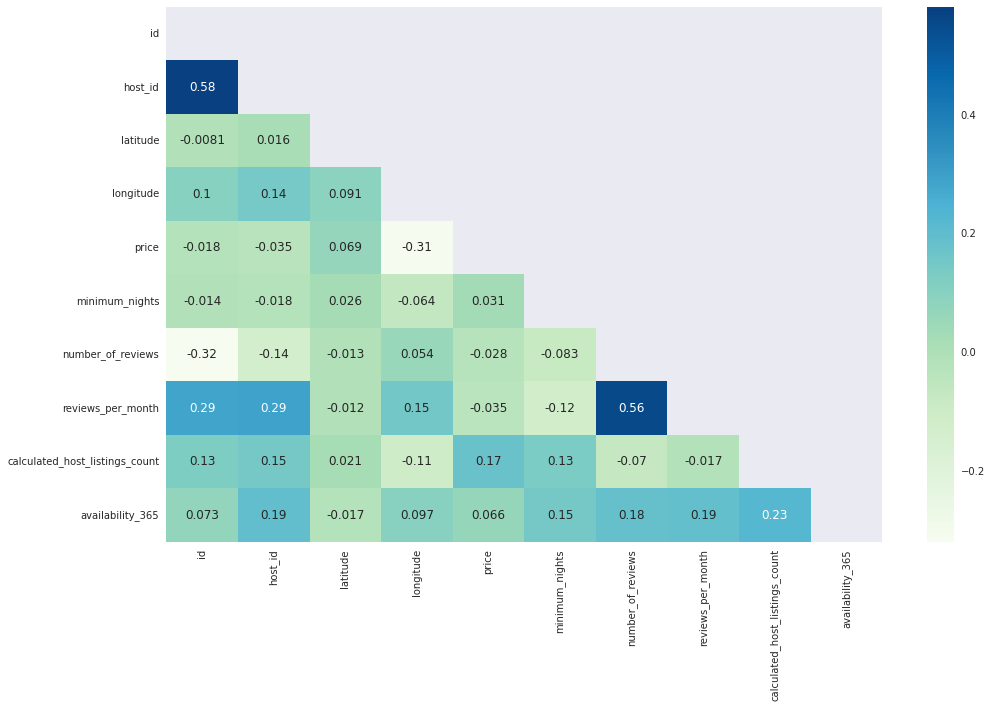

In [ ]:
plt.figure(figsize=(15,10))
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, annot=True, cmap="GnBu")
plt.tight_layout()

#Data Cleaning and Preparation

In [ ]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Filling null values

In [ ]:
data[data['last_review'].isnull()][['number_of_reviews','reviews_per_month']].head()

,number_of_reviews,reviews_per_month
2,0,NaN
19,0,NaN
26,0,NaN
36,0,NaN
38,0,NaN


If a certain listing has a null for its "last_review," that means it has not gotten a review at all(also proved from previous dataframe), so "reviews_per_month" must be 0. 
Also, now we can drop the last-review column containing null values from a cleaner dataset.


In [ ]:
data.fillna({'reviews_per_month':0}, inplace=True)
data.drop('last_review', inplace=True, axis=1)
data.isnull().sum()

id                                 0
name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

Let's drop the columns that will not affect the price prediction.

In [ ]:
data.drop(["id", "name", "host_id", "host_name"], axis = 1, inplace = True)

Applying log transformation for the price column.

In [ ]:
data["price"] = np.log1p(data["price"])
X = data.drop("price", axis = 1)
y = data["price"]

# Splitting data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

#Feature Encoding

In [ ]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
columns = ["neighbourhood_group", "neighbourhood", "room_type"]
ohe_df_train = pd.DataFrame(ohe.fit_transform(X_train[columns]).toarray(), columns=ohe.get_feature_names_out())
X_train_ohe = X_train.join(ohe_df_train).drop(columns, axis=1)

ohe_df_test = pd.DataFrame(ohe.transform(X_test[columns]).toarray(), columns=ohe.get_feature_names_out())
X_test_ohe = X_test.join(ohe_df_test).drop(columns, axis=1)

#Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_ohe)
X_test = scaler.transform(X_test_ohe)

#Model Building and Comparison

In [ ]:
classic_ml_models = []
ensemble_bagging_methods = []
ensemble_boosting_methods = []

**Function for prediction and evaluation**

In [ ]:
def test_models(X_train, X_test, y_train, y_test, model, model_name, models):
    y_pred = model.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = model.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    row = {"Model": model_name, "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}

    display(pd.DataFrame([row]))
    models.append(row)

Funtion for visualising the results together for comparison

In [ ]:
sns.set_style("dark", {'axes.grid' : False})
def compare_models(models):
    display(models.style.highlight_min(subset=["MAE","MSE","RMSE", "RMSE CV"], color = '#379949', axis = 0)\
                        .highlight_max(subset=["Test Sc."], color = '#379949', axis = 0)\
                        .highlight_min(subset=["Test Sc.",], color = '#b4241c', axis = 0)\
                        .highlight_max(subset=["MAE","MSE","RMSE", "RMSE CV"], color = '#b4241c', axis = 0))
    
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    plt.subplots_adjust(hspace=1.2)
    sns.lineplot(x=models["Model"], y=models["Test Sc."], ax=ax1, marker="o", color="#b4241c")
    sns.lineplot(x=models["Model"], y=models["Train Sc."], ax=ax2, marker="o", color="#b4241c")
    sns.lineplot(x=models["Model"], y=models["MAE"], ax=ax3, marker="o", color="#b4241c")
    sns.lineplot(x=models["Model"], y=models["MSE"], ax=ax4, marker="o", color="#b4241c")
    sns.lineplot(x=models["Model"], y=models["RMSE"], ax=ax5, marker="o", color="#b4241c")
    sns.lineplot(x=models["Model"], y=models["RMSE CV"], ax=ax6, marker="o", color="#b4241c")
    ax1.set_title("Test Scores Comparison", size=8)
    ax2.set_title("Train Scores Comparison", size=8)
    ax3.set_title("MAE Scores Comparison", size=8)
    ax4.set_title("MSE Scores Comparison", size=8)
    ax5.set_title("RMSE Scores Comparison", size=8)
    ax6.set_title("RMSE CV Scores Comparison", size=8)
    ax1.tick_params(labelrotation=30)
    ax2.tick_params(labelrotation=30)
    ax3.tick_params(labelrotation=30)
    ax4.tick_params(labelrotation=30)
    ax5.tick_params(labelrotation=30)
    ax6.tick_params(labelrotation=30)
    plt.show()

##Classic ML models

###Linear Regression

In [ ]:
'''
lr = LinearRegression()
lr.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, lr, "Linear Regression", classic_ml_models)
'''

'\nlr = LinearRegression()\nlr.fit(X_train, y_train)\ntest_models(X_train, X_test, y_train, y_test, lr, "Linear Regression", classic_ml_models)\n'

###Ridge regression

In [ ]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, ridge, "Ridge Regression",classic_ml_models )

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge Regression,0.550181,0.537237,0.334657,0.212804,0.461306,0.478069


###Lasso Regression

In [ ]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, lasso, "Lasso Regression", classic_ml_models)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Lasso Regression,0.54993,0.537223,0.334679,0.212923,0.461435,0.477871


###Decision Tree

In [ ]:
dtr = DecisionTreeRegressor(min_samples_leaf=60)
dtr.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, dtr, "Decision Tree", classic_ml_models)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Decision Tree,0.571749,0.600147,0.326018,0.2026,0.450111,0.467157


###Comparison of classic ML methods

Green Highlights the best model, and Red highlights the worst.


,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge Regression,0.550181,0.537237,0.334657,0.212804,0.461306,0.478069
1,Lasso Regression,0.549930,0.537223,0.334679,0.212923,0.461435,0.477871
2,Decision Tree,0.571749,0.600147,0.326018,0.202600,0.450111,0.467157


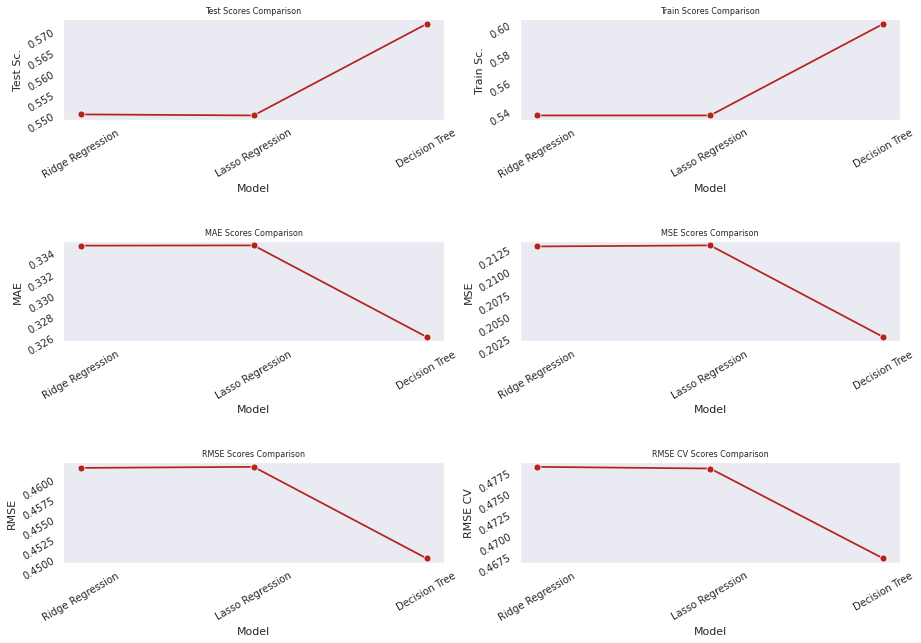

In [ ]:
print("Green Highlights the best model, and Red highlights the worst.")
compare_models(pd.DataFrame(classic_ml_models))

##Bagging Ensemble Methods

###Random Forest

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
test_models(X_train, X_test, y_train, y_test, rfr, "Random Forest Baseline", ensemble_bagging_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest Baseline,0.610617,0.943354,0.305292,0.184212,0.4292,0.44789


In [ ]:
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rfr.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}




### **Hyper parameter Tuning**

In [ ]:
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}

rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = param_grid,
                               n_iter = 10, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=30,
                                                   max_features='sqrt',
                                                   min_samples_split=5,
                                                   random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30}

In [ ]:
best_rf = rf_random.best_estimator_
test_models(X_train, X_test, y_train, y_test, best_rf, "Random Forest Best", ensemble_bagging_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest Best,0.618835,0.816573,0.302152,0.180325,0.424646,0.442793


###Extra-Tree Regressor

In [ ]:
etr = ExtraTreesRegressor()
etr.fit(X_train,y_train)
test_models(X_train, X_test, y_train, y_test, etr, "Extra-Tree", ensemble_bagging_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Extra-Tree,0.597289,0.999997,0.309537,0.190518,0.436483,0.45801


In [ ]:
print('Parameters currently in use: \n')
pprint(etr.get_params())

Parameters currently in use: 

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}



### **Hyper Parameter Tuning**



In [ ]:
param_grid = {'n_estimators': [50, 100, 150, 200, 300],
              'max_depth': [10, 20, 30, 40],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5],
              'max_features': ['auto', 'sqrt', 'log2']}
etr_random = RandomizedSearchCV(estimator = etr, param_distributions = param_grid,
                               n_iter = 10, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)

In [ ]:
etr_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300]},
                   random_state=42, verbose=2)

In [ ]:
etr_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30}

In [ ]:
best_etr = etr_random.best_estimator_
test_models(X_train, X_test, y_train, y_test, best_etr, "Extra-Tree Best", ensemble_bagging_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Extra-Tree Best,0.62428,0.818201,0.299365,0.177748,0.421602,0.444318


###**Comparison of Bagging Methods**

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest Baseline,0.610617,0.943354,0.305292,0.184212,0.429200,0.447890
1,Random Forest Best,0.618835,0.816573,0.302152,0.180325,0.424646,0.442793
2,Extra-Tree,0.597289,0.999997,0.309537,0.190518,0.436483,0.458010
3,Extra-Tree Best,0.624280,0.818201,0.299365,0.177748,0.421602,0.444318


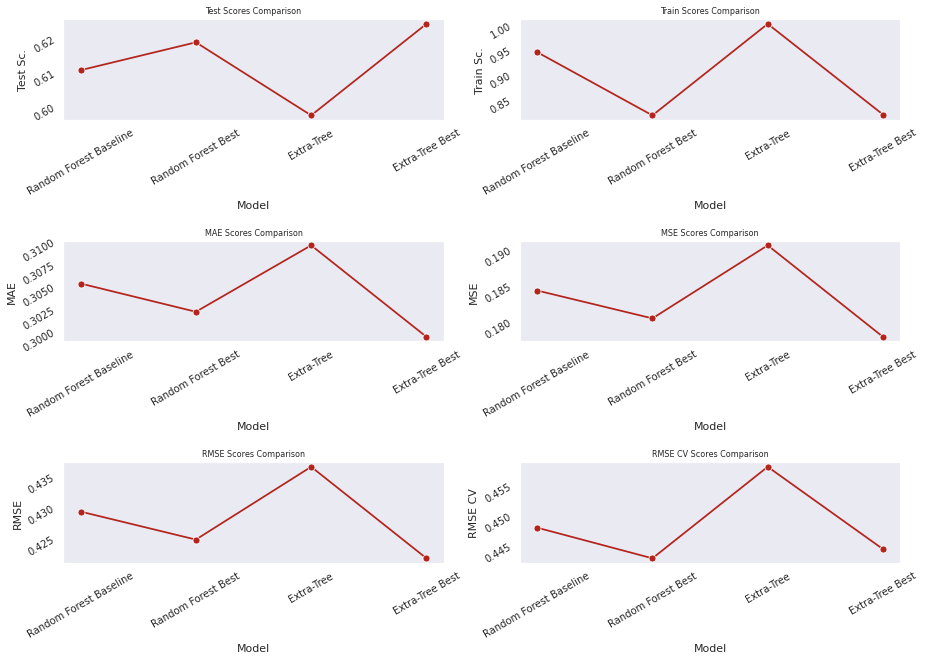

In [ ]:
compare_models(pd.DataFrame(ensemble_bagging_methods))

##Boosting Ensemble Methods

###Gradient Bossting

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
test_models(X_train, X_test, y_train, y_test, gbr, "Gradient Boosting", ensemble_boosting_methods)

In [ ]:
print('Parameters currently in use: \n')
pprint(gbr.get_params())



> Hyper-parameter Tuning



###XGBoost

In [ ]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train,y_train)
test_models(X_train, X_test, y_train, y_test, xgbr, "XGBoost", ensemble_boosting_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,XGBoost,0.617609,0.695833,0.306616,0.180904,0.425329,0.443907


###CATBOOST

In [ ]:
cbr = cb.CatBoostRegressor(silent=True)
cbr.fit(X_train,y_train)
test_models(X_train, X_test, y_train, y_test, cbr, "CATBoost", ensemble_boosting_methods)

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,CATBoost,0.625589,0.659899,0.301692,0.177129,0.420867,0.439599


###Comparison of Boosting Methods

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Gradient Boosting,0.592304,0.590188,0.315626,0.192876,0.439177,0.453500
1,XGBoost,0.617609,0.695833,0.306616,0.180904,0.425329,0.443907
2,CATBoost,0.625589,0.659899,0.301692,0.177129,0.420867,0.439599


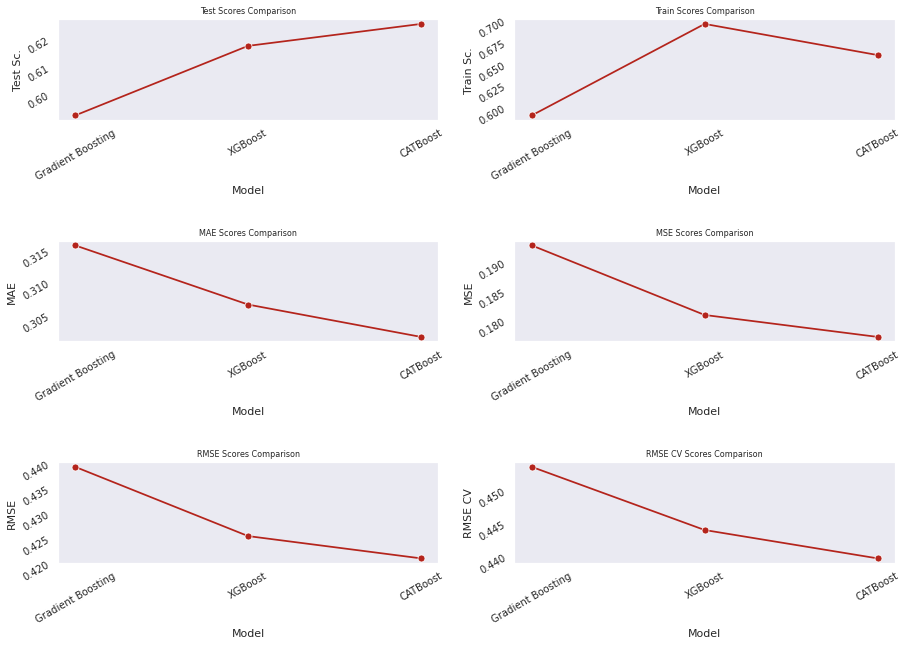

In [ ]:
compare_models(pd.DataFrame(ensemble_boosting_methods))

##Comparison of Ensemble methods

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Random Forest,0.617602,0.742756,0.302837,0.180908,0.425333,0.444327
1,Extra-Tree,0.593690,0.999997,0.310904,0.192220,0.438429,0.458242
2,Gradient Boosting,0.592304,0.590188,0.315626,0.192876,0.439177,0.453500
3,XGBoost,0.617609,0.695833,0.306616,0.180904,0.425329,0.443907
4,CATBoost,0.625589,0.659899,0.301692,0.177129,0.420867,0.439599


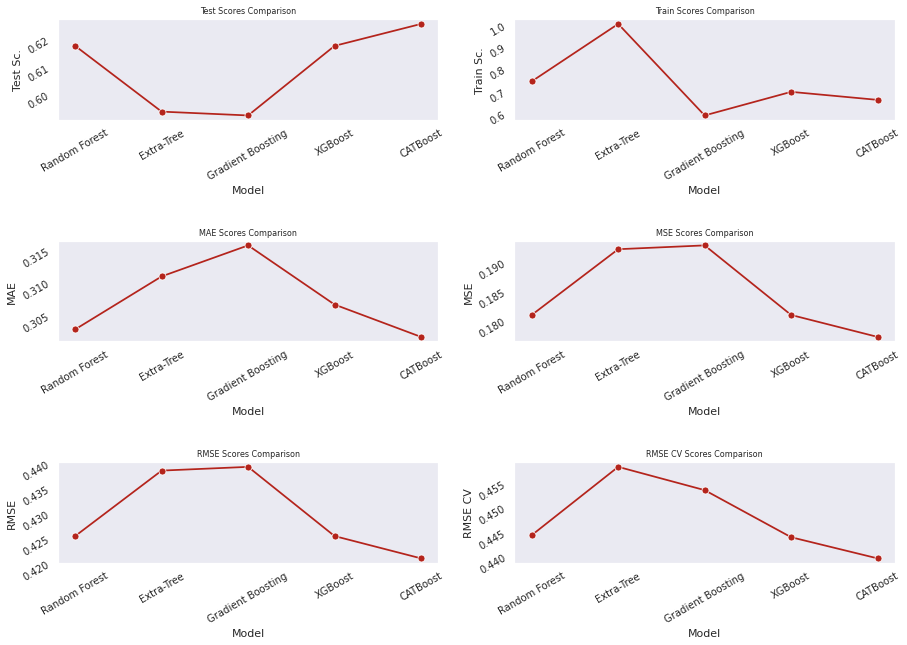

In [ ]:
compare_models(pd.DataFrame(ensemble_bagging_methods+ensemble_boosting_methods))

#Comparing all models together

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge Regression,0.550181,0.537237,0.334657,0.212804,0.461306,0.478069
1,Lasso Regression,0.549930,0.537223,0.334679,0.212923,0.461435,0.477871
2,Decision Tree,0.571749,0.600147,0.326018,0.202600,0.450111,0.467157
3,Random Forest,0.617602,0.742756,0.302837,0.180908,0.425333,0.444327
4,Extra-Tree,0.593690,0.999997,0.310904,0.192220,0.438429,0.458242
5,Random Forest Baseline,0.608797,0.943237,0.306223,0.185073,0.430202,0.448052
6,Gradient Boosting,0.592304,0.590188,0.315626,0.192876,0.439177,0.453500
7,XGBoost,0.617609,0.695833,0.306616,0.180904,0.425329,0.443907
8,CATBoost,0.625589,0.659899,0.301692,0.177129,0.420867,0.439599


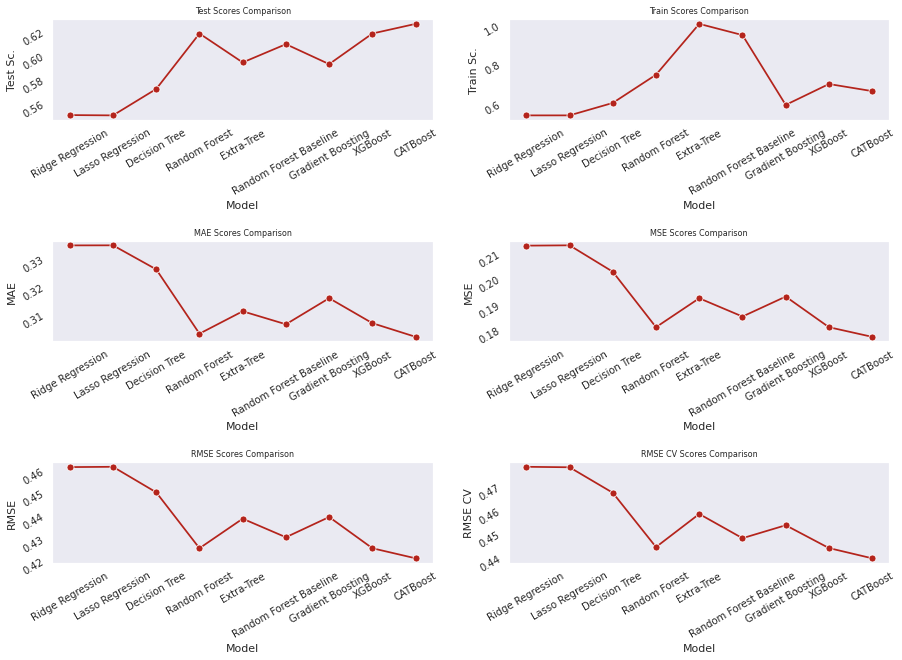

In [ ]:
compare_models(pd.DataFrame(classic_ml_models+ensemble_bagging_methods+ensemble_boosting_methods))